# Building an MNIST Digit Classifier using Cirkit


## Goals

By the end of this tutorial you will:

* Know how to build a multi-class classifier using cirkit
* Understand how to train the model both generatively and discriminatively
* Learn to deal with missing inputs by marginalising them out
* Use circuits to detect outputs that are Out Of Distribution (OOD)


In this notebook we will loosely follow the [RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a.pdf).
For the paper, the authors had to implement all the circuit operations from scratch in tensorflow, because Cirkit did not exist!

### Enter Cirkit &#x1F50C; &#x26A1;	
Cirkit's modularity makes building circuits like those used in the RAT SPN paper extremely easy.
We will show this by:

1. Reimplementing the MNIST experiments of the RAT SPN paper with just a few lines of code
2. Illustrating how to easily adapt/improve models with plug & play modules

# Load Image Data  &#x1F5BC;	&#x1F5B4;

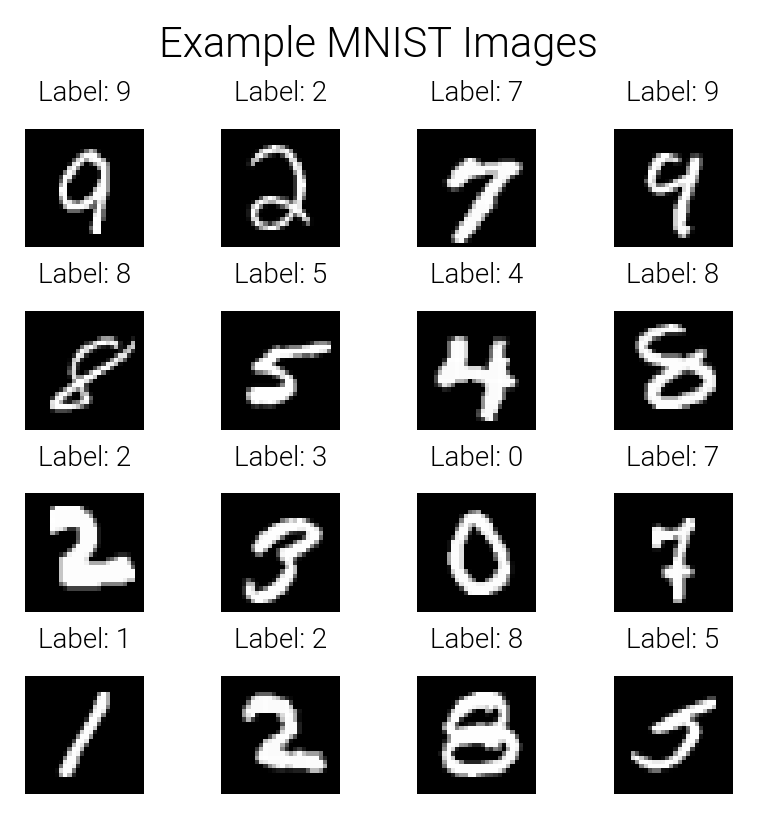

In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets


PIXEL_RANGE= 255
IMAGE_SIZE = [28, 28]
NUM_PIXELS_IN_IMAGE = np.prod(IMAGE_SIZE)

NUM_CLASSES = 10 # Number of digits in MNIST

# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: {'images': (PIXEL_RANGE * x).long()})
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    inputs, labels = next(iter(dataloader))
    
    example_image = inputs['images'][0]
    images = inputs['images'][:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images', fontsize=30)
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

train_size = int(.8 * len(data_train))
valid_size = len(data_train) - train_size

torch.manual_seed(13)
train_split, valid_split = random_split(data_train, [train_size, valid_size])

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(train_split, shuffle=True, batch_size=256)
valid_dataloader = DataLoader(valid_split, shuffle=False, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(valid_dataloader, gridsize=4)

# Building a Digit Classifier using Cirkit &#x1F50C;

In this section, we show how to train our circuit such that it can classify MNIST digits. As usual with neural network training, we want to find the model parameters, $\theta$, that minimise our loss function:

$$
\operatorname{argmin}_{\theta} \mathcal{L}(\theta)
$$

We will show 3 ways of training by varying how we define $\mathcal{L}$:

1. Generative Training
2. Discriminative Training
3. Combination of Both (i.e. using a multi-task objective)

### Notation

* $\mathbf{x}$ are the pixels of an image
* $y$ is the MNIST digit class, i.e. $y \in \{0,\ldots,9\}$
* $N$ is the number of training examples
* $\theta$ are the parameters of our circuit
* $\mathcal{L}$ is the loss of our network


## 1. Generative Training Loss: $\mathcal{L}_{gen}$

The generative training loss is the average negative log-likelihood of each image and MNIST digit label pair:

$$\mathcal{L}_{gen}(\theta) = - \frac{1}{N} \sum_{i=1}^N \log p(\mathbf{x}^{(i)}, y^{(i)})$$

### Modelling $p(\mathbf{x}, y)$

We have:
$$
\begin{align}
\log p(\mathbf{x}, y) &= \log \Bigl( p(\mathbf{x} \mid y) p(y) \Bigr) \\
&= \log p(\mathbf{x} \mid y) + \log p(y)
\end{align}
$$

#### Assume $p(y)$ is uniform
While we can estimate $p(y)$ from the data, for simplicity we will assume $p(y)$ is a uniform distibution.
In this case we have:

$$
\begin{align}
\operatorname{argmin}_{\theta} \Bigl( - \log p(\mathbf{x}, y) \Bigr) &= \operatorname{argmin}_{\theta} \Bigl( - \log p(\mathbf{x} \mid y) - \log p(y) \Bigr)& \text{(Assume $p(y)$ is uniform)} \\
&= \operatorname{argmin}_{\theta} - \log p(\mathbf{x} \mid y) &
\end{align}
$$

As such, we are therefore looking for the $\theta$ that minimizes the negative conditional log-likelihood, $-\log p(\mathbf{x} \mid y)$. **But how do we construct a circuit to give us the conditional distributions, $p(\mathbf{x} \mid y)$?**

### Estimating $p(\mathbf{x} \mid y)$

Recall that in the [earlier notebook]((https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb)) we were modelling $p(\mathbf{x})$; our circuit had a single log-probability output, which we interpreted as $\log p(\mathbf{x})$.
In our case, we could instead fit $10$ separate circuits, one per image class. However, this is wasteful.
Images have shared characteristics that all $10$ circuits would have to learn separately, from scratch.
Can we do better?


### Shared Representations
Yes! We can share the early layers of our circuit and only adapt the output layer to produce our conditional distributions.
Since there are $10$ classes, we change the last layer of our circuit to output $10$ log-probabilities: the probability mass over images conditioned on each class, $p(\mathbf{x} \mid y)$.
We can do so by specifying the `num_classes` option in `data_modalities.image_data`.

### Class Conditional Circuits
As in our earlier notebooks, we have a choice for the region graph and input parametrisations.
As can be seen below, we use a similar setup as previous notebooks, but we change the `num_classes` argument to be 10 and use QuadGraph, as opposed to the RandomBinaryTree used in the [RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a-supp.pdf).

In [142]:
from cirkit.templates import data_modalities
from cirkit.templates.utils import Parameterization
from cirkit.symbolic.circuit import Circuit


def build_class_conditional_circuit(num_classes: int,
                                    region_graph: str,
                                    sum_prod_layer: str = 'cp') -> Circuit:
    circuit = data_modalities.image_data(
        (1, *IMAGE_SIZE),           # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
        region_graph=region_graph,  # Select the structure of the circuit to follow the region graph
        input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
        num_input_units=64,         # Each input layer consists of 64 Categorical input units
        sum_product_layer=sum_prod_layer,     # Use CP sum-product layers, i.e., alternate dense layers with Hadamard product layers
        num_sum_units=64,           # Each dense sum layer consists of 64 sum units
        sum_weight_param=Parameterization(
            activation='softmax',   # Parameterize the sum weights by using a softmax activation
            initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
        ),
        num_classes=num_classes     # *** Note difference from earlier calls. *** Set number of output classes
    )
    return circuit


# Example usage
# circuit = build_class_conditional_circuit(NUM_CLASSES, 'quad-tree-2', 'cp')

### Class Conditional Generative Loss in Code

From the `log_probs` we obtain from the 10 heads of our class conditional circuit and the labels of each image[<sup>1</sup>](#fn1) , we can train our model generatively by using the following class conditional generative loss:

```python
def generative_loss(log_probs, labels):
    batch_size, num_classes = log_probs.shape

    d_log_probs = log_probs[torch.arange(batch_size), labels]
    # Compute average over examples (1/N)
    # Negative since max log likelihood = min negative log likelihood
    return -torch.mean(d_log_probs)
```

<span style="font-size: .75em;"> [<sup id="fn1">1</sup>](#fn1-back) Note that if we do not have access to labels for some examples, we can also fit $p(\mathbf{x})$ by marginalising out $y$. </span>


## 2. Discriminative Training Loss:  $\mathcal{L}_{dis}$

The discriminative training loss is the **cross-entropy** between the target distribution, $p^*$, and our predicted distribution, $p$:
$$
\begin{align}
\mathcal{L}_{dis}(\theta) &= -\frac{1}{N} \sum_{i=1}^N \underbrace{\sum_{y' \in \{0,\ldots,9\}} p^*(y' \mid \mathbf{x}^{(i)}) \log p(y' \mid \mathbf{x}^{(i)})}_{\text{cross-entropy}}
\end{align}
$$

However, in our case $p^*$ is the empirical distribution, i.e. for the $i^{th}$ example, $p^*$ is a one-hot categorical positioned on the target label, $y^{(i)}$:

$$
p^*(y' \mid \mathbf{x}^{(i)}) = \left\{
\begin{array}{ll}
1 & y' = y^{(i)} \\
0 & \text{otherwise} \\
\end{array}
\right.
$$
Because $p^*$ is one-hot, the cross-entropy is equivalent to the conditional negative log-likelihood of the target label, i.e.:

$$
\begin{align}
\mathcal{L}_{dis}(\theta) &= -\frac{1}{N} \sum_{i=1}^N \sum_{y' \in \{0,\ldots,9\}} p^*(y' \mid \mathbf{x}^{(i)}) \log p(y' \mid \mathbf{x}^{(i)}) &  \\
                  &= - \frac{1}{N}\sum_{i=1}^N \left( 1 \log p(y^{(i)} \mid \mathbf{x}^{(i)}) + \sum_{y' \neq y^{(i)}} 0 \log p(y' \mid \mathbf{x}^{(i)}) \right) & \text{$p^*$ is one-hot} \\
                  &= - \frac{1}{N} \sum_{i=1}^N \log p(y^{(i)} \mid \mathbf{x}^{(i)}) & \text{negative log-likelihood}
\end{align}
$$


Ok, but till now we had $p(\mathbf{x}^{(i)} \mid y^{(i)})$, but we want $p(y^{(i)} \mid \mathbf{x}^{(i)})$.


### Converting our Generator into a Classifier via Bayes' rule

We can use Bayes' rule to flip $p(\mathbf{x} \mid y)$ to our required $p(y \mid \mathbf{x})$.

$$p(y \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid y)p(y)}{\sum_y p(\mathbf{x} \mid y)p(y)}$$

### Uniform Prior $p(y)$
While we could estimate $p(y)$ empirically, we assume a uniform prior here for simplicity. Doing so allows us to simplify the above expression to:

$$p(y \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid y)}{\sum_y p(\mathbf{x} \mid y)}$$

### Working with $\log$ Probabilities

As a last step, for numerical reasons our circuit outputs log probabilities, so we rewrite the above in terms of log probabilities as:

$$\log p(y \mid \mathbf{x}) = \log p(\mathbf{x} \mid y) - \log \sum_y p(\mathbf{x} \mid y)$$

Since our circuit outputs log probabilities, in order to compute the sum on the right we use a `logsumexp` operation.

Great, so we can now estimate the probability of an image class given an image! What's more, we can train using this discriminative loss:

### Discriminative Loss in Code
```python
def discriminative_loss(log_probs, labels):
    batch_size, num_classes = log_probs.shape
    # Select log p(x | y) where y is the true label
    target_log_prob = log_probs[torch.arange(batch_size), labels]
    # Compute log p(y | x)
    d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
    return -torch.mean(d_log_probs)
```

## 3. Combining Both Objectives

<div style="max-width:25%; margin: auto;">

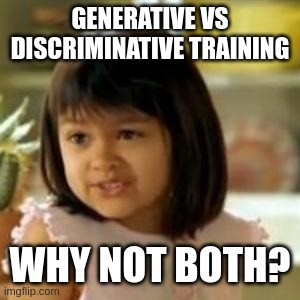

</div>

The RAT SPN paper also considers training using a trade-off between the two objectives.
To do so, it introduces a parameter $\lambda \in [0, 1]$ and minimize a combined loss:

$$
\operatorname{argmin}_{\theta} \mathcal{L}(\theta)\quad \text{where} \quad \mathcal{L}(\theta) = \lambda \mathcal{L}_{dis}(\theta) + (1-\lambda) \frac{\mathcal{L}_{gen}(\theta)}{|X|}
$$

where we divide $\mathcal{L}_{gen}(\theta)$ by the number of pixels in the image, $|X|$, such that the losses are on a comparable scale[<sup>2</sup>](#fn2).

* $\lambda = 0  \rightarrow$ Model trained only generatively
* $\lambda = 1  \rightarrow$ Model trained only discriminatively
* $\lambda \in (0, 1) \rightarrow$ Trade-off between losses

<span style="font-size: .75em;"> [<sup id="fn2">2</sup>](#fn2-back) Note that $\mathcal{L}_{gen}$ and $\mathcal{L}_{dis}$ are on different scales, primarily because they are defined on a different number of random variables.
$\mathcal{L}_{dis}$ is defined over a single random variable, $y$, while $\mathcal{L}_{gen}$ is defined over $28 \times 28=784$ pixels.
To interpolate on a more reasonable scale, we therefore divide $\mathcal{L}_{gen}$ by $|X|$, i.e. $784$ in our case. </span>


### Both Objectives in Code
Below we put everything together in the `MNISTClassifier` class and then we train some circuits[<sup>3</sup>](#fn3) while varying $\lambda$.


<span style="font-size: .75em;">  [<sup id="fn3">3</sup>](#fn3-back) This experiment is optimised for running time and exposition of the main ideas and not to obtain state of the art results, you can get better results by training a larger model for longer or with better hyperparameters, see the next steps section at the end of the tutorial for some ideas.</span>

In [143]:
from copy import deepcopy
from collections import defaultdict

from cirkit.backend.torch.queries import IntegrateQuery
from cirkit.utils.scope import Scope
from cirkit.pipeline import compile


max_num_epochs = 10
eval_every = 200


def plot_stats(stats):
    # Plot figures of results
    fig, axes = plt.subplots(figsize=(20, 15), ncols=3, nrows=2, sharex=True)
    for k, v in stats.items():
        v = v['train']
        xx = np.arange(1, len(v['gen_loss'])+1)
        lbl = k.replace('lambda ', '$\\lambda$=')
        axes[0, 0].plot(xx, v['gen_loss'], '-o', label=lbl)
        axes[0, 1].plot(xx, v['dis_loss'], '-o', label=lbl)
        axes[0, 2].plot(xx,[a * 100 for a in v['accuracy']], '-o', label=lbl)
        
    for k, v in stats.items():
        v = v['valid']
        xx = np.arange(1, len(v['valid_gen_loss'])+1)
        lbl = k.replace('lambda ', '$\\lambda$=')
        axes[1, 0].plot(xx, v['valid_gen_loss'], '-o', label=lbl)
        axes[1, 1].plot(xx, v['valid_dis_loss'], '-o', label=lbl)
        axes[1, 2].plot(xx,[a * 100 for a in v['valid_accuracy']], '-o', label=lbl)
    
    axes[0, 0].set_title('$\\mathcal{L}_{gen}$')
    axes[0, 1].set_title('$\\mathcal{L}_{dis}$')
    axes[0, 2].set_title('Accuracy')
    axes[1, 0].set_xlabel('# Train Steps x %d' % eval_every)
    axes[1, 1].set_xlabel('# Train Steps x %d' % eval_every)
    axes[1, 2].set_xlabel('# Train Steps x %d' % eval_every)

    axes[0, 0].set_ylabel('Training')
    axes[1, 0].set_ylabel('Validation')

    
    plt.suptitle('Effect of $\\lambda$:  $\\lambda \\mathcal{L}_{dis} + (1-\\lambda) \\mathcal{L}_{gen}$', fontsize=40)
    plt.legend(bbox_to_anchor=(1., 1.), fontsize=22)
    plt.tight_layout()
    plt.show()


class MNISTClassifier(object):

    """A class that implements class conditional classifiers for circuits.
    It includes helper functions for computing generative and discriminative
    loss and interpolating between the two."""

    def __init__(self, model, interpolation=.5, scale_gen=1., scale_dis=1.):
        self.model = model
        self.marginal_query = IntegrateQuery(self.model)
        assert 0 <= interpolation <= 1
        self.interpolation = interpolation
        self.scale_gen = scale_gen
        self.scale_dis = scale_dis

    def __call__(self, **kwargs):

        xx = kwargs['images']
        yy = kwargs['labels']
        mm = kwargs.get('masks', None)

        assert xx.shape[0] == yy.shape[0]
        
        if mm is None:
            log_probs = self.model(xx)
        else:
            assert len(mm) in (xx.shape[0], 1)
            log_probs = self.marginal_query(xx, integrate_vars=mm)            

        batch_size, num_channels, num_classes = log_probs.shape
        assert num_channels == 1
        assert num_classes > 1

        # Remove channel dim (which is one)
        log_probs = log_probs.squeeze(dim=1)

        gen_loss = self.generative_loss(log_probs, yy, marginalize=False)
        dis_loss = self.discriminative_loss(log_probs, yy)

        # lambda * CE(w) - (1-lambda) LL(w)
        loss = self.interpolation * dis_loss * self.scale_dis + (1 - self.interpolation) * gen_loss * self.scale_gen

        probs = torch.exp(log_probs - torch.logsumexp(log_probs, dim=1, keepdims=True))

        image_log_probs = self.image_log_probs(log_probs)

        return dict(loss=loss,
                    probs=probs,
                    image_log_probs=image_log_probs,
                    gen_loss=gen_loss,
                    dis_loss=dis_loss)
    
    @staticmethod
    def image_log_probs(log_probs, prior=None):
        # Compute p(x) by marginalising out y, i.e. sum_i p(x|y)p(y)
        # Set prior to uniform if not set
        batch_size, num_classes = log_probs.shape
        
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
        return d_log_probs

    @staticmethod
    def cond_image_log_probs(log_probs, labels):
        # Compute conditional probability p(x|y) where y is the known class of the image
        batch_size, num_classes = log_probs.shape
        
        d_log_probs = log_probs[torch.arange(batch_size), labels]
        return d_log_probs
        
    @staticmethod
    def generative_loss(log_probs, labels, marginalize=False, prior=None):
        if marginalize:
            d_log_probs = MNISTClassifier.image_log_probs(log_probs, prior=prior)
        else:
            # Select the logprob given by y - i.e. the true label
            d_log_probs = MNISTClassifier.cond_image_log_probs(log_probs, labels)
        return -torch.mean(d_log_probs)

    @staticmethod
    def discriminative_loss(log_probs, labels):
        batch_size, num_classes = log_probs.shape
        # Select log p(x | y) where y is the true label
        target_log_prob = log_probs[torch.arange(batch_size), labels]
        # Compute log p(y | x)
        d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
        return -torch.mean(d_log_probs)


def train_model(circuit, train_dataloader, valid_dataloader, interpolation=.5):
    # Set some seeds
    np.random.seed(42)
    torch.manual_seed(42)

    # Set the torch device to use
    device = torch.device('cuda')
    
    cc = compile(circuit)
    # Move the circuit to chosen device
    cc = cc.to(device)
    cc.train()
    
    
    model = MNISTClassifier(cc,
                            interpolation=interpolation,
                            scale_gen=1./NUM_PIXELS_IN_IMAGE,
                            scale_dis=1.)

    total_patience = 3
    patience = total_patience
    criterion = 'valid_accuracy' 
    current_criterion = -np.inf
    
    best_model = deepcopy(model)
    
    step_idx = 0
    num_examples = 0
    stats, step_stats = defaultdict(lambda: defaultdict(list)), defaultdict(float)
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(cc.parameters(), lr=0.02)

    epoch_idx = 0
    while epoch_idx < max_num_epochs and patience > 0:
        for i, ((inputs), labels) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            if masks is not None:
                masks = masks.to(device)
            
            result = model(images=images, labels=labels, masks=masks)
            
            loss = result['loss']
            loss.backward()
    
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
    
            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())
            
            step_stats['loss'] += loss.detach().item() * BS
            step_stats['accuracy'] += acc.detach().item() * BS
            step_stats['gen_loss'] += result['gen_loss'].detach().item() * BS
            step_stats['dis_loss'] += result['dis_loss'].detach().item() * BS

            step_idx += 1
            num_examples += BS
            if step_idx % eval_every == 0:
                for k, v in step_stats.items():
                    step_stats[k] = step_stats[k] / num_examples
                progress = "\tEpoch %d Step %s" % (epoch_idx, step_idx)
                print_log = f"{progress}: Train Loss: {step_stats['loss']:.3f} Train Acc: {step_stats['accuracy'] * 100:.2f}%"

                for k, v in step_stats.items():
                    stats['train'][k].append(v)

                # Evaluate
                valid_stats = eval_model(model, valid_dataloader, mode='valid')
                    
                if valid_stats[criterion] > current_criterion:
                    current_criterion = valid_stats[criterion]
                    best_model = deepcopy(model)
                    patience = total_patience
                else:
                    patience -= 1

                print_log += f" | Valid Loss: {valid_stats['valid_loss']:.3f} Valid Acc: {valid_stats['valid_accuracy'] * 100:.2f}%"
                print_log += " | patience: %d" % patience
                print(print_log, end='\r')

                for k, v in valid_stats.items():
                    stats['valid'][k].append(v)
                
                if patience == 0:
                    break

                model.model.train()
                step_stats = defaultdict(float)
                num_examples = 0
        epoch_idx += 1

    return best_model, stats


def eval_model(classifier, dataloader, mode='test'):
    stats = defaultdict(float)
    device = classifier.model.device
    
    with torch.no_grad():
        test_lls = 0.0
        classifier.model.eval()

        N = 0
        for inputs, labels in dataloader:

            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            if masks is not None:
                masks = masks.to(device)
            
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            result = classifier(images=images, labels=labels, masks=masks)

            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())

            stats['%s_accuracy' % mode] += acc.detach().item() * BS
            stats['%s_loss' % mode] += result['loss'].detach().item() * BS
            stats['%s_gen_loss' % mode] += result['gen_loss'].detach().item() * BS
            stats['%s_dis_loss' % mode] += result['dis_loss'].detach().item() * BS
    
            N += BS
    
        # Compute average test log-likelihood and bits per dimension
        for k, v in stats.items():
            stats[k] = stats[k] / N

    return stats

## Train the circuits for various $\lambda$



Training QuadGraph $\lambda=$0.00...

	Epoch 9 Step 1800: Train Loss: 0.843 Train Acc: 89.96% | Valid Loss: 0.858 Valid Acc: 89.15% | patience: 2

Training QuadGraph $\lambda=$0.25...

	Epoch 6 Step 1200: Train Loss: 0.670 Train Acc: 99.96% | Valid Loss: 0.695 Valid Acc: 96.86% | patience: 0

Training QuadGraph $\lambda=$0.50...

	Epoch 6 Step 1200: Train Loss: 0.474 Train Acc: 99.97% | Valid Loss: 0.537 Valid Acc: 96.35% | patience: 0

Training QuadGraph $\lambda=$0.75...

	Epoch 6 Step 1200: Train Loss: 0.252 Train Acc: 99.98% | Valid Loss: 0.340 Valid Acc: 96.43% | patience: 0

Training QuadGraph $\lambda=$1.00...



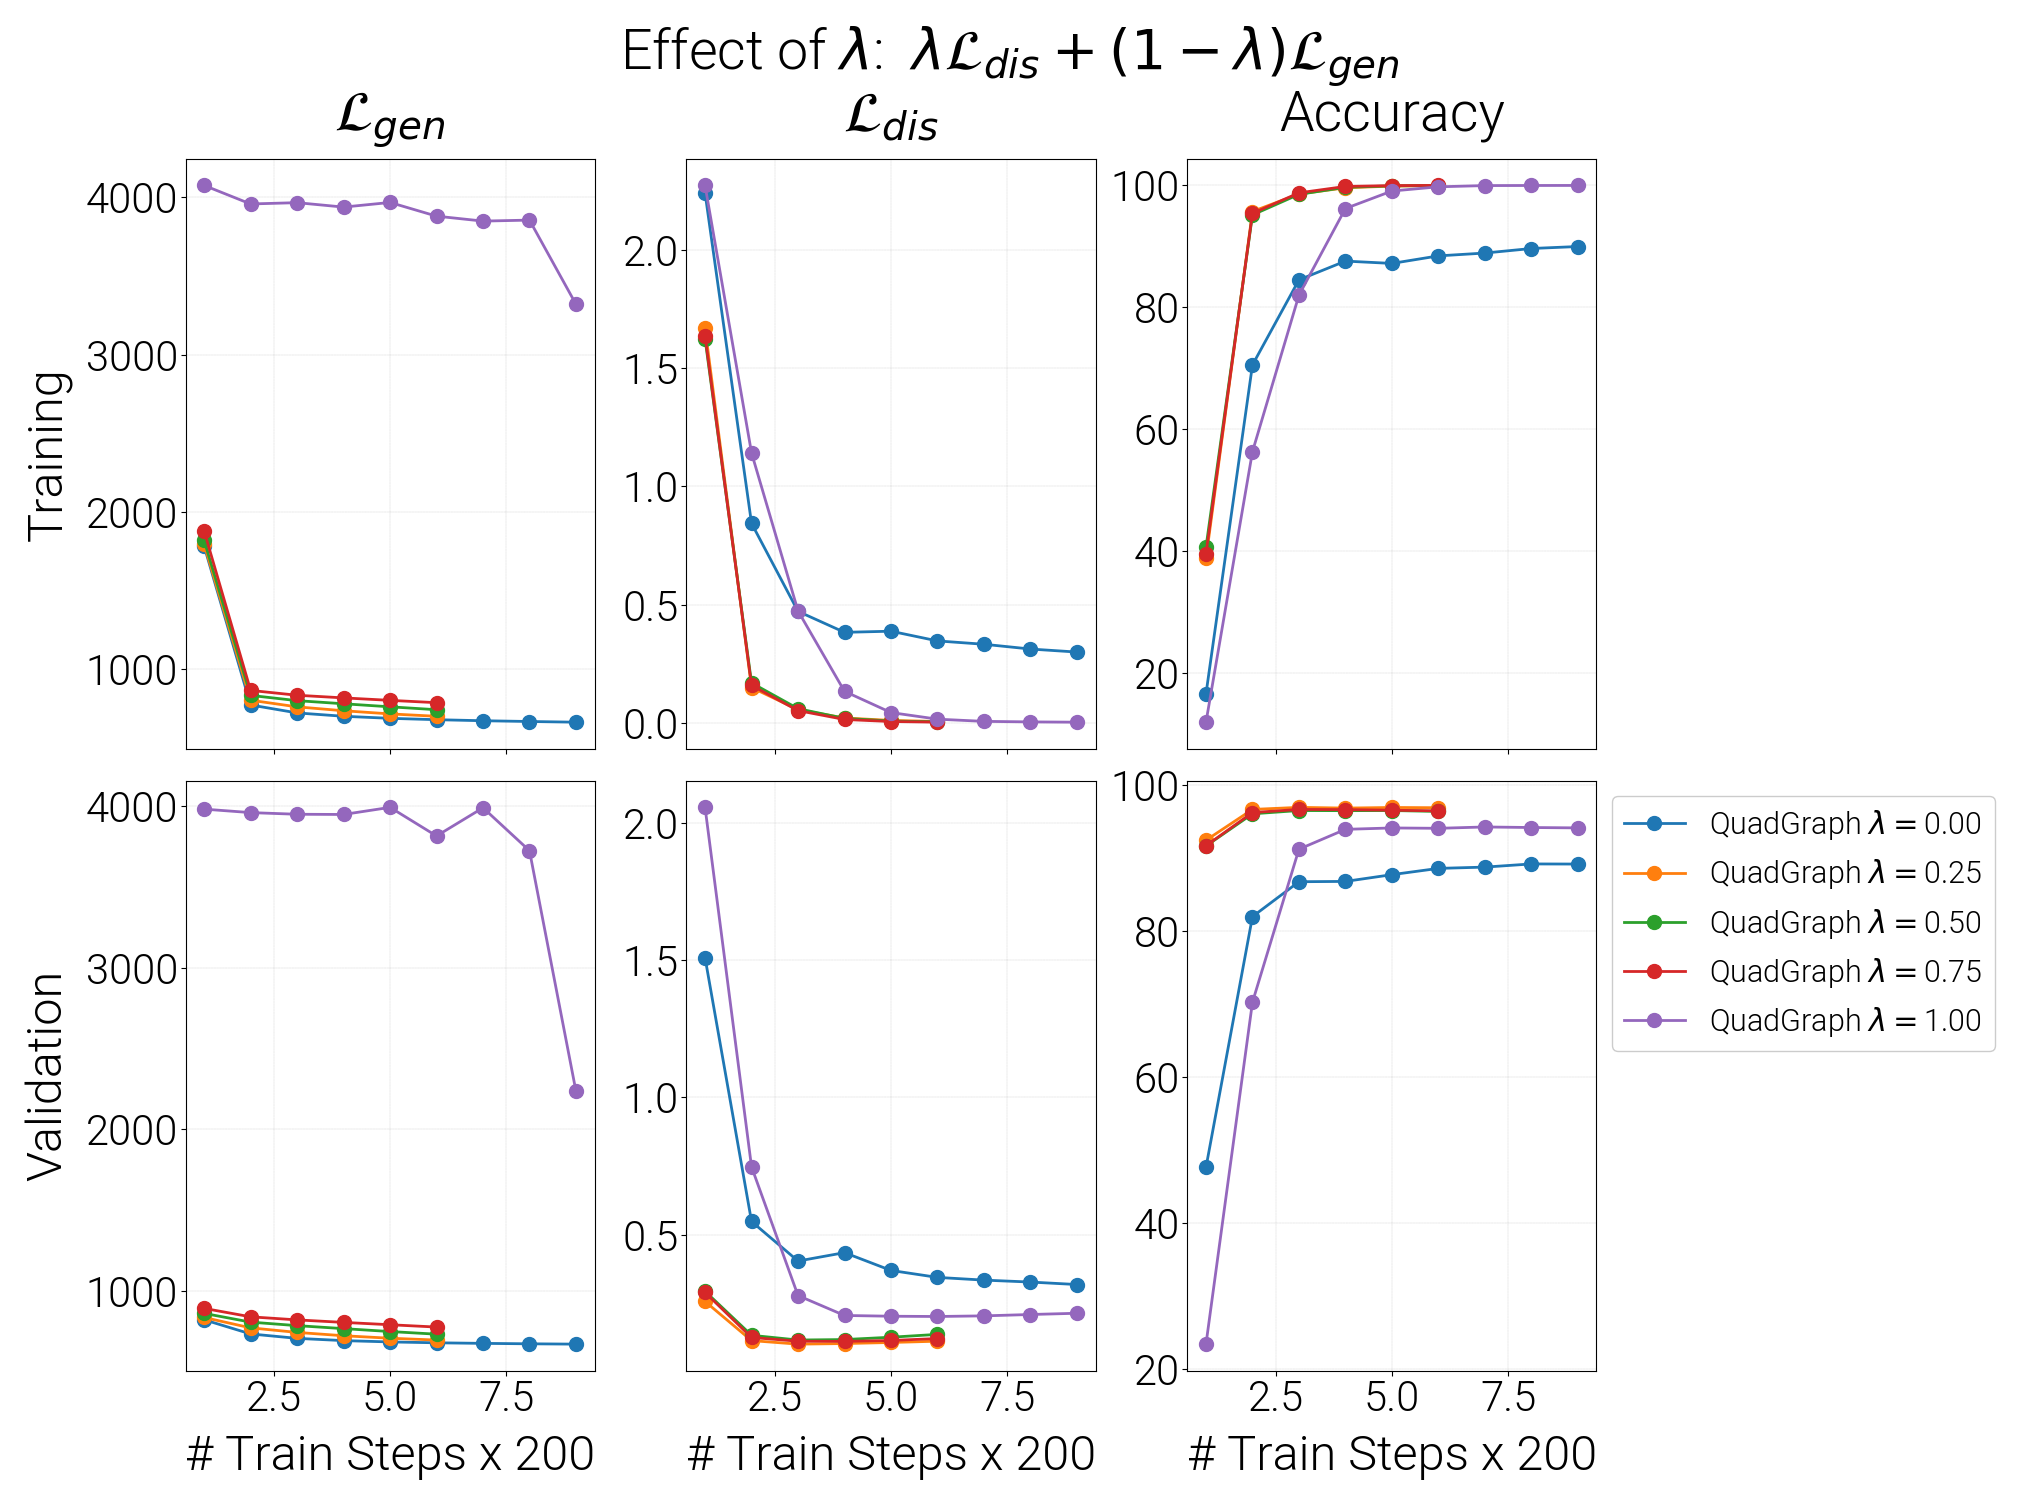

In [144]:
models, stats = dict(), dict()
# Train models with different interpolation
for lamda in [0., .25, .5, .75, 1.]:
    circuit = build_class_conditional_circuit(NUM_CLASSES, 'quad-graph', 'cp')
    model_name = 'QuadGraph $\\lambda=$%.2f' % lamda
    print('\n\nTraining %s...\n' % model_name)
    models[model_name], stats[model_name] = train_model(circuit, train_dataloader, valid_dataloader, interpolation=lamda)
plot_stats(stats)

## Evaluate the circuits on the test set

In [145]:
import pandas as pd

# Test models
test_stats = dict()
for k, model in models.items():
    test_stats[k] = eval_model(model, test_dataloader, mode='test')

df = pd.DataFrame.from_dict(test_stats, orient='index')
df

,test_accuracy,test_loss,test_gen_loss,test_dis_loss
QuadGraph $\lambda=$0.00,0.8962,0.856072,671.160388,0.317449
QuadGraph $\lambda=$0.25,0.9673,0.736987,742.395496,0.107149
QuadGraph $\lambda=$0.50,0.9622,0.562760,785.035678,0.124199
QuadGraph $\lambda=$0.75,0.9653,0.346380,821.468174,0.112576
QuadGraph $\lambda=$1.00,0.9446,0.196180,3989.731081,0.196180


## Conclusion
We have built several digit classifiers using cirkit.
As perhaps expected, the model trained solely generatively ($\lambda=0$) does not outperform the model trained solely discriminatively ($\lambda=1$) in terms of **test accuracy**. However, interpolating both objectives is best, since we get better generalisation (e.g. see $\lambda=0.25$ in the table above), while also enjoying faster convergence during training.

# Circuits are Robust Under Missing Features

## Dealing with missing inputs
Sometimes we need to model data with missing inputs!
In our case, we drop pixels from the image.
In order to use our model, we marginalise out the random variables that correspond to the dropped pixels.


## Example

Let's visualise what it looks like to drop $p\%$ of the pixels from an image, dropped pixels shown in orange below for $p \in [10, 25, 50, 75]$.

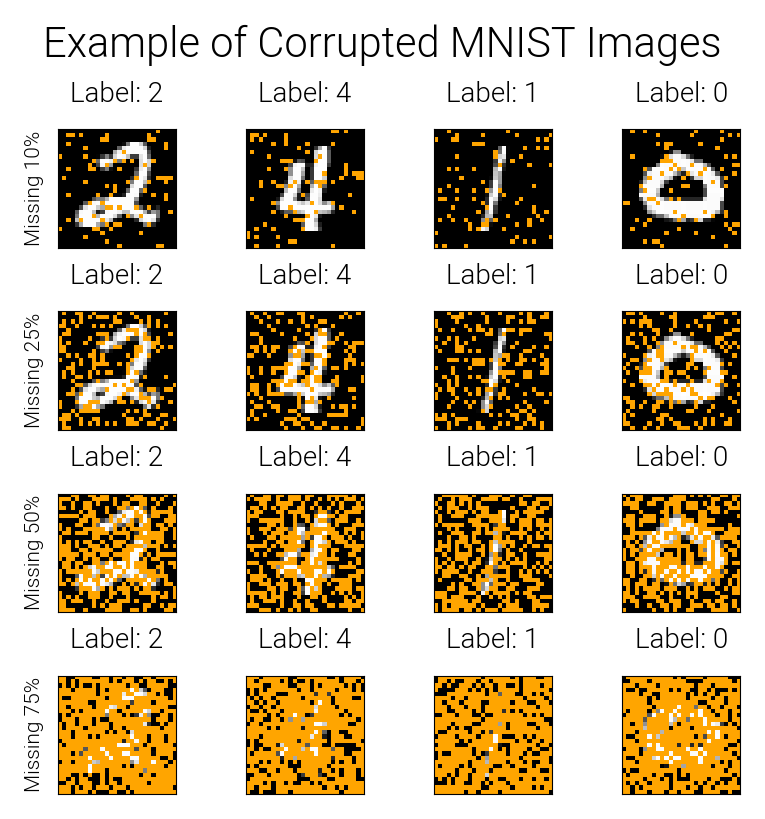

In [146]:
def sample_masks(image_size, num_images, p=.5):
    num_pixels = np.prod(image_size)
    num_samples = int(p*num_pixels)
    masks = [list(np.random.choice(range(np.prod(image_size)), size=num_samples, replace=False))
             for i in range(num_images)]
    return masks


def mask_to_image(image_size, mask):
    bool_mask = np.zeros(np.prod(image_size), dtype=bool)
    bool_mask[mask] = True
    bool_mask = bool_mask.reshape(image_size)
    return bool_mask


gridsize = 4

inputs, labels = next(iter(train_dataloader))
images = inputs['images'][:4].repeat(gridsize, 1, 1, 1)
labels = labels[:4].repeat(gridsize)

fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

dropout = [.1, .25, .5, .75]

for i in range(gridsize):
    axes[i, 0].set_ylabel('Missing %d%%' % int(dropout[i]* 100), rotation=90, fontsize=15)
# Plot each image
for i, ax in enumerate(axes.flat):
    # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
    img = images[i].numpy().squeeze()
    img = img.reshape(*IMAGE_SIZE, 1)
    img = img.repeat(4, axis=2)
    mask = sample_masks(IMAGE_SIZE, 1, p=dropout[i//gridsize])
    mask = mask_to_image(IMAGE_SIZE, mask)
    img[:, :, -1] = ~mask * 255

    # Display the image
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Help distinguish between white pixels and missing pixels (in red)
    ax.set_facecolor("orange")
    ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
# Adjust spacing between subplots
fig.suptitle('Example of Corrupted MNIST Images', fontsize=30)
plt.tight_layout()
plt.show()

# Solution
We can handle this in cirkit by marginalising out the random variables which correspond to missing inputs.

In [147]:
def mask_transform(p):
    return transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range and append randomly generated mask
    transforms.Lambda(lambda x: {'images':(PIXEL_RANGE * x).long(),
                                 'masks': mask_to_image(IMAGE_SIZE, sample_masks(IMAGE_SIZE, 1, p=p)).ravel()})
    ])

dropout = np.arange(0, 1., .1)

m_test_stats = []
for p in dropout:

    m_data_test = datasets.MNIST('datasets', train=False, download=True, transform=mask_transform(p))

    # Instantiate the training and testing data loaders
    mask_test_dataloader = DataLoader(m_data_test, shuffle=False, batch_size=2)

    for k, model in models.items():
        stats = eval_model(model, mask_test_dataloader, mode='test')
        stats['p'] = p
        stats['model'] = k
        m_test_stats.append(stats)

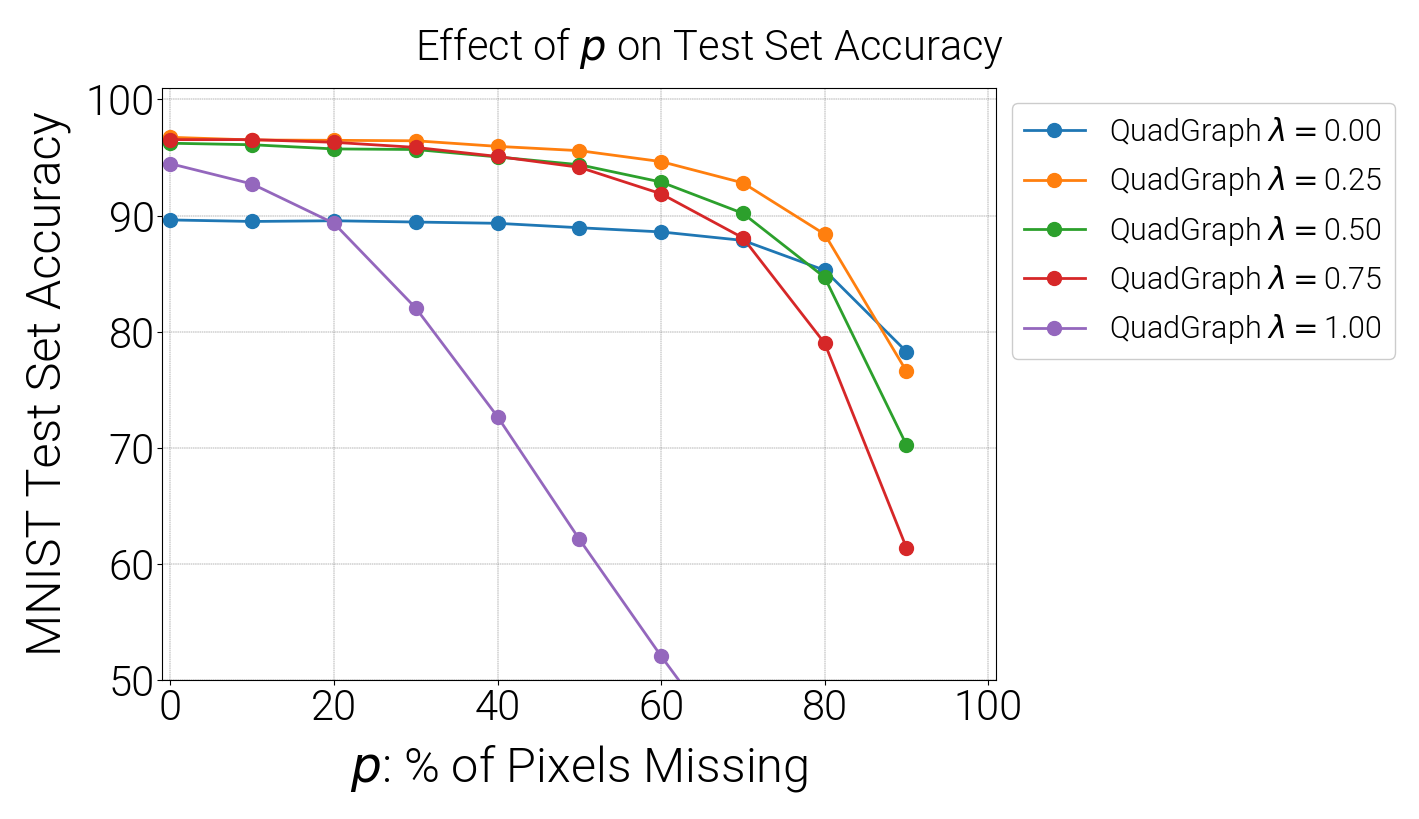

In [148]:
fig, ax = plt.subplots(figsize=(14, 8))

for name, e in pd.DataFrame.from_records(m_test_stats).groupby(['model']):
    ax.plot(e['p'] * 100, e['test_accuracy'] * 100, '-o', label=name)
plt.xlabel('$p$: % of Pixels Missing')
plt.ylabel('MNIST Test Set Accuracy')

plt.suptitle('Effect of $p$ on Test Set Accuracy', fontsize=30)
plt.legend(bbox_to_anchor=(1., 1.), fontsize=22)
plt.ylim([50, 101])
plt.xlim([-1, 101])
plt.tight_layout()
plt.grid(True, linewidth=.3)
plt.show()

# Group by below is for visualisation purposes (index).
# Each group contains a single row, so just take that using first().
# df = pd.DataFrame.from_records(m_test_stats).groupby(['model', 'p']).first()
# df

In the plot above we see how randomly dropping $p\%$ of the pixels (x-axis) affects the test set accuracy of our classifier (y-axis).
As can be seen, for the classifier trained using only the discriminative loss ($\lambda=1$), dropping only $20\%$ of the pixels is enough to create almost a $10\%$ drop in classification performance. In contrast, the classifier trained purely generatively ($\lambda=0$), has almost no drop in test classification performance until about $50\%$ of the pixels are dropped.

## Conclusion

The more weight we give to our generative loss ($\lambda=0$ means generative only), the more robust to missing features our classifier becomes. By mixing both discriminative and generative losses we get the best of both worlds, by balancing test set performance and robustness to missing features.

# Circuits Know What They Do Not Know

We can use circuits for Out of Distribution Detection (OOD).
To illustrate this, we will use the circuit trained on MNIST and evaluate the log-likelihood of images from **MNIST** and an *unseen dataset*, **Fashion MNIST**.


## Load Fashion MNIST as unseen dataset

Each training and test example is assigned to one of the following labels:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

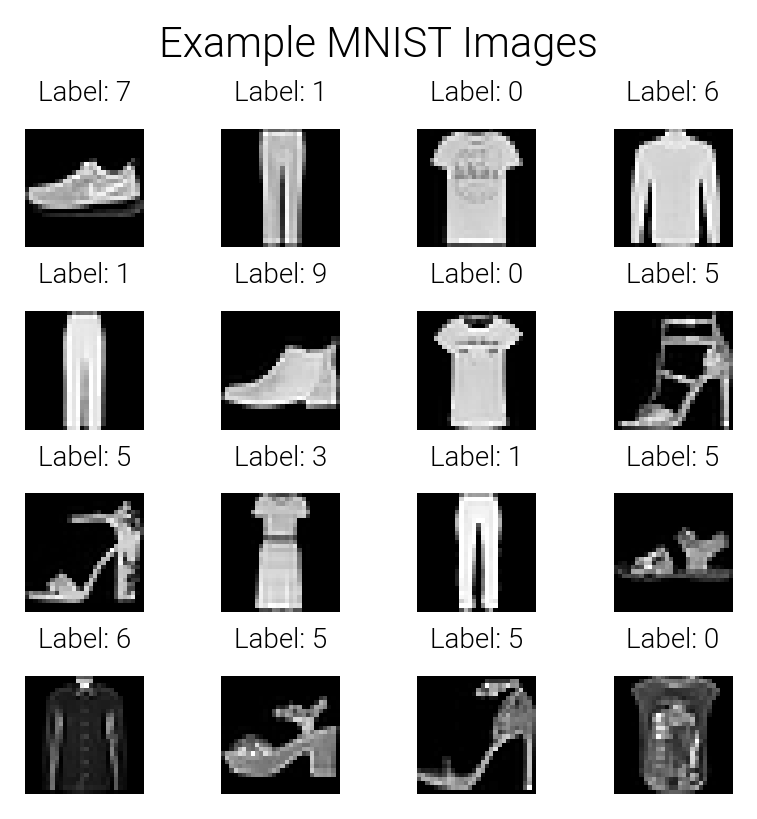

In [149]:
f_data_train = datasets.FashionMNIST('datasets', train=True, download=True, transform=transform)

# Instantiate the training and testing data loaders
f_train_dataloader = DataLoader(f_data_train, shuffle=True, batch_size=256)

plot_sample_images(f_train_dataloader, gridsize=4)

Below we compute the log likelihood of images from:
1. MNIST (training set)
2. MNIST (test set)
3. Fashion MNIST: an example Out Of Distribution (OOD) dataset

In [150]:
loaders = [train_dataloader, test_dataloader, f_train_dataloader]
loader_names = ['train (MNIST)', 'test (MNIST)', 'OOD: Fashion MNIST']

scores = defaultdict(lambda: defaultdict(list))
for k, model in models.items():
    with torch.no_grad():
        for loader in loaders:
            ls = str(loader)
            for inputs, labels in loader:
                BS = labels.shape[0]
                device = model.model.device
                images = inputs['images'].view(BS, 1, -1).to(device)
                labels = labels.view(BS).to(device)
                log_probs = model(images=images, labels=labels)['image_log_probs']
                log_probs = log_probs.detach().cpu().numpy()
                scores[k][ls].append(log_probs)

for m, vals in scores.items():
    for k in vals.keys():
        scores[m][k] = np.hstack(scores[m][k])

# Results

If our circuit is succesfully modelling MNIST digits, it should assign them a large log likelihood.
At the same time, images from other datasets, e.g. Fashion MNIST, should be assigned a lower log likelihood.

Below we plot histograms of the log likelihood assigned by each model to the above examples.
As can be seen from the histogram, the circuit indeed assigns much lower log likelihood to examples from fashion MNIST.

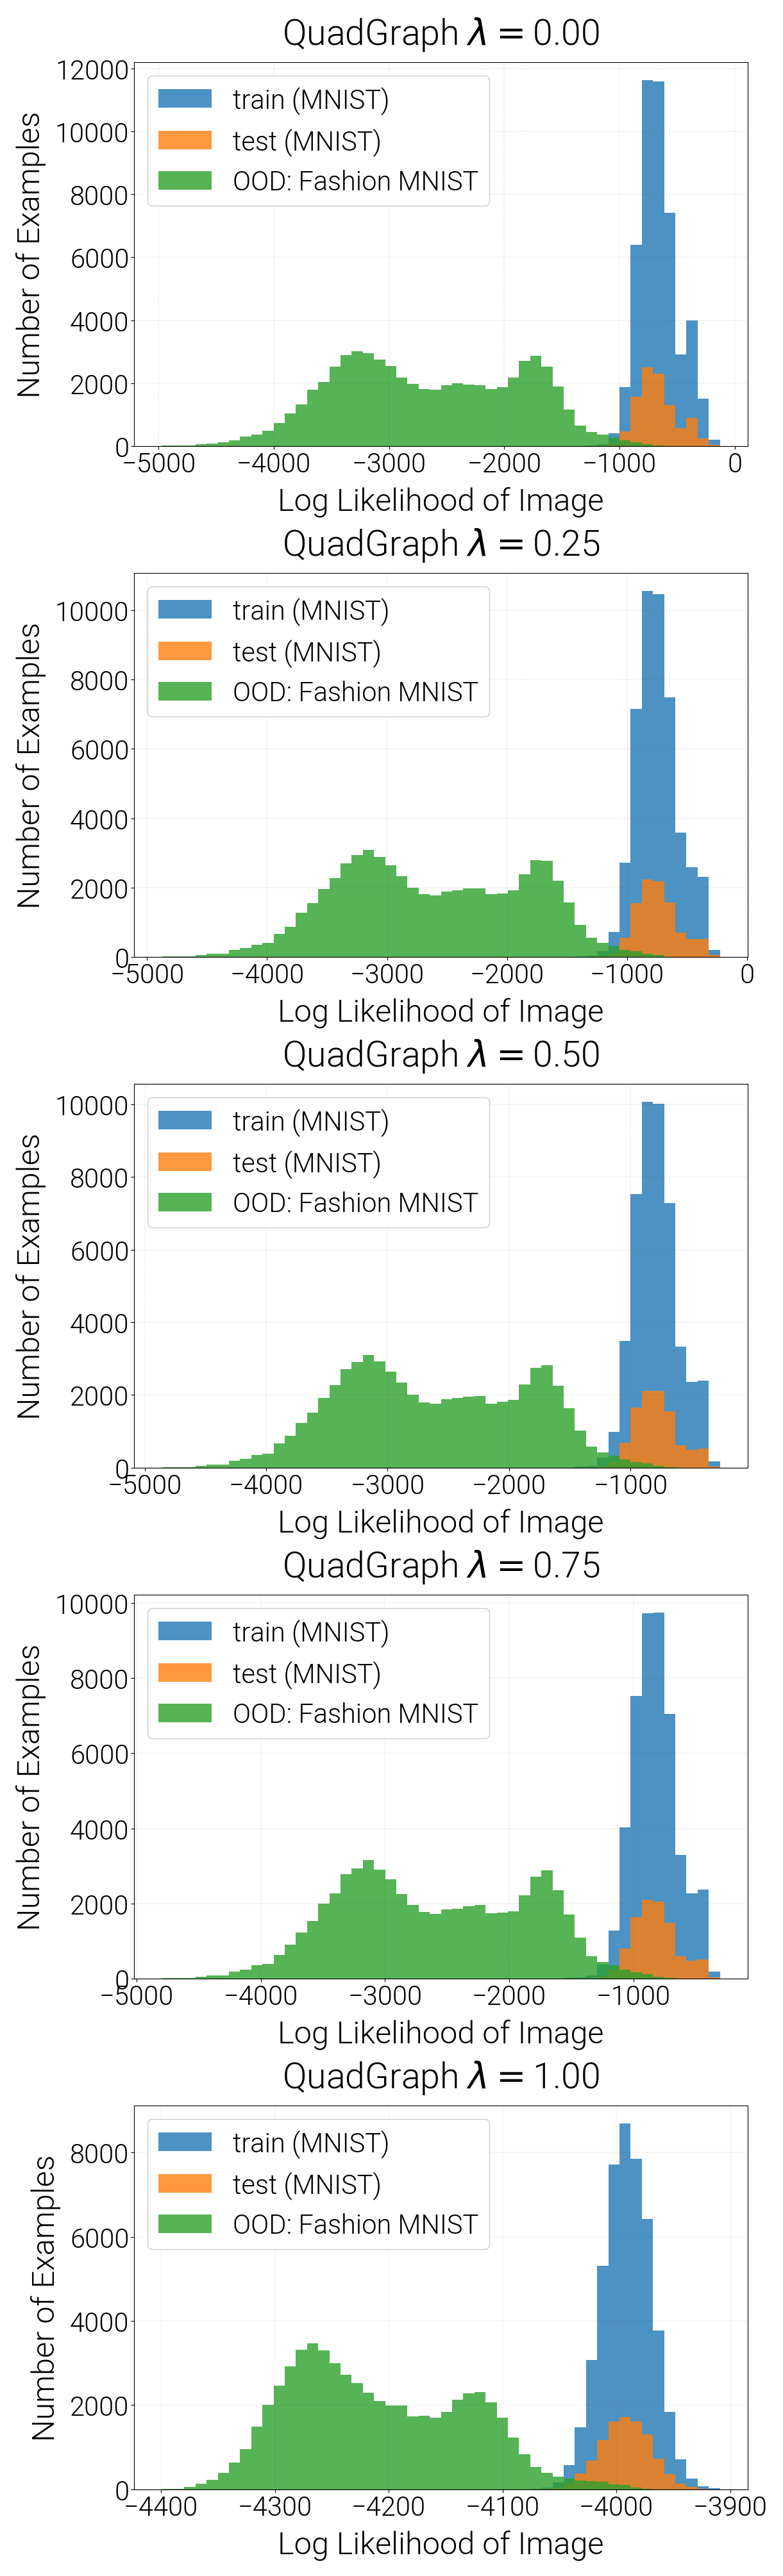

In [151]:
for m, vals in scores.items():
    for k in vals.keys():
        scores[m][k] = np.hstack(scores[m][k])


fig, axes = plt.subplots(nrows=len(models), squeeze=0, figsize=(12, 8*len(models)))
axes = axes.reshape(-1)
                         
for i, (m, vals) in enumerate(scores.items()):
    bins = np.histogram(np.hstack([v for v in vals.values()]), bins=50)[1]
    for j, k in enumerate(vals.keys()):
        axes[i].hist(scores[m][k], bins, density=False, label=loader_names[j], alpha=.8)
    axes[i].set_xlabel('Log Likelihood of Image')
    axes[i].set_ylabel('Number of Examples')
    axes[i].set_title(m)
    axes[i].legend()
plt.tight_layout()
plt.show()

## Conclusion

Circuits trained with a generative loss component can be used for Out of Distribution Detection. Circuits trained solely with a discriminative loss ($\lambda=1$) do not give good estimates of the likelihood of an image (e.g. note that the log-likelihood of images in the last plot is lower than $-3800$ vs $\approx -200$ for $\lambda=0$). While the models trained generatively have a larger separation between the unseen Fashion MNIST dataset and the MNIST dataset which our circuit was trained on, this separation is present but smaller for the model trained discriminatively.

# Summary


Circuits are cool and cirkit makes using them a lot easier! We have seen:

1. How to build a multi-class classifier from a circuit and train it generatively, discriminatively and with a combined multi-task objective, which gives us the best of both worlds.
2. How to work with missing data by marginalising out missing inputs. As we saw, circuits trained generatively are robust in performance even after marginalising out many features.
3. How to do Out Of Distribution (OOD) estimation with circuits. As we saw, circuits can help us distinguish whether an image is from MNIST or Fashion MNIST (OOD).


However, we have only scratched the surface!

# What Next?

Some ideas for thing you may want to explore further:

* In earlier notebooks we learned about more region graphs that are good for images. Can you adapt this notebook to use these?
* We have also learned about SoS and PICs, can we get better results with these?
* In the RAT-SPN paper, "dropout" is also used during training. Apply input dropout by marginalising out random subsets of features during training.